In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal as mvn

from jax import grad
import jax.numpy as jnp
import jax.scipy.stats.multivariate_normal as jmvn
from jax.scipy.stats import gaussian_kde as jgaussian_kde

from stein_thinning.thinning import thin, thin_gf

### Generate from a multivariate normal mixture model

For multivariate normal distributions with pdfs
$$f_i(x) = \frac{1}{(2\pi)^{d/2} |\Sigma_i|^{1/2}}\exp\left(-\frac{1}{2}(x - \mu_i)^T \Sigma_i^{-1}(x-\mu_i)\right),$$
where $x \in \mathbb{R}^d$, the mixture pdf with $k$ components is given by
$$f(x) = \sum_{i=1}^k w_i f_i(x),$$
thus the score function is obtained as
$$\nabla \log f(x) = \frac{\sum_{i=1}^k w_i \nabla f_i(x)}{\sum_{i=1}^k w_i f_i(x)} = -\frac{\sum_{i=1}^k w_i f_i(x) \Sigma_i^{-1}(x - \mu_i)}{\sum_{i=1}^k w_i f_i(x)}.$$

Define the functions for the parameters of a multivariate Gaussian mixture:

In [2]:
def make_mvn_mixture(weights, means, covs):
    # invert covariances
    covs_inv = np.linalg.inv(covs)

    k, d = means.shape
    assert weights.shape == (k,)
    assert covs.shape == (k, d, d)
    
    def rvs(size, random_state):
        component_samples = [
            mvn.rvs(mean=means[i], cov=covs[i], size=size, random_state=random_state) for i in range(len(weights))
        ]
        indices = rng.choice(len(weights), size=size, p=weights)
        return np.take_along_axis(np.stack(component_samples, axis=1), indices.reshape(size, 1, 1), axis=1).squeeze()

    def logpdf(x):
        f = np.stack([mvn.pdf(x, mean=means[i], cov=covs[i]) for i in range(len(weights))])
        return np.log(np.einsum('i,il->l', weights, f))
    
    def score(x):
        # centered sample
        xc = x[np.newaxis, :, :] - means[:, np.newaxis, :]
        # pdf evaluations for all components and all elements of the sample
        f = np.stack([mvn.pdf(x, mean=means[i], cov=covs[i]) for i in range(len(weights))])
        # numerator or the score function
        num = np.einsum('i,il,ijk,ilk->lj', weights, f, covs_inv, xc)
        # denominator or the score function
        den = np.einsum('i,il->l', weights, f)
        return -num / den[:, np.newaxis]
    
    def logpdf_jax(x):
        probs = jmvn.pdf(x.reshape(-1, 1, d), mean=means.reshape(1, k, d), cov=covs.reshape(1, k, d, d))
        return jnp.squeeze(jnp.log(jnp.sum(weights * probs, axis=1)))
    
    return rvs, logpdf, score, logpdf_jax

Choose the parameters of the mixture:

In [3]:
w = np.array([0.3, 0.7])
means = np.array([
    [-1., -1.],
    [1., 1.],
])
covs = np.array([
    [
        [0.5, 0.25],
        [0.25, 1.],
    ],
    [
        [2.0, -np.sqrt(3.) * 0.8],
        [-np.sqrt(3.) * 0.8, 1.5],
    ]
])

In [4]:
rvs, logpdf, score, logpdf_jax = make_mvn_mixture(w, means, covs)

Obtain a sample from the mixture:

In [5]:
rng = np.random.default_rng(12345)
sample_size = 1000
sample = rvs(sample_size, random_state=rng)

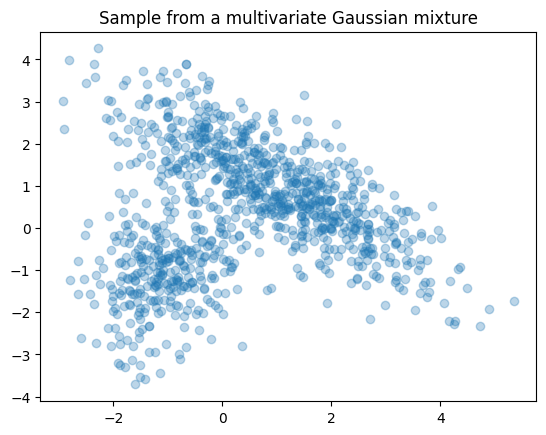

In [6]:
fig, ax = plt.subplots()
ax.scatter(sample[:, 0], sample[:, 1], alpha=0.3);
ax.set_title('Sample from a multivariate Gaussian mixture');

Verify log-pdf against the JAX implementation:

In [7]:
np.testing.assert_array_almost_equal(logpdf(sample), logpdf_jax(sample))

Verify the score function against the JAX implementation:

In [8]:
gradient = score(sample)

In [9]:
score_jax = grad(logpdf_jax)
gradient_jax = jnp.apply_along_axis(score_jax, 1, sample)

In [10]:
np.testing.assert_array_almost_equal(gradient, gradient_jax)

### Apply Stein thinning

In [11]:
thinned_size = 40
idx_stein = thin(sample, gradient, thinned_size)

### Simple gradient-free Stein thinning

Define a proxy distribution to be the multivariate normal with the same mean and covariance matrices as the sample mean and covariance:

In [12]:
sample_mean = np.mean(sample, axis=0)
sample_cov = np.cov(sample, rowvar=False, ddof=1)

Gradient-free Stein thinning requires us to provide the log-pdf of the proxy distribution and its score function:

In [13]:
log_q = mvn.logpdf(sample, mean=sample_mean, cov=sample_cov)
gradient_q = -np.einsum('ij,kj->ki', np.linalg.inv(sample_cov), sample - sample_mean)

We also need the log-pdf of the target distribution:

In [14]:
log_p = logpdf(sample)

We get the indices of the points to select:

In [15]:
idx_gf = thin_gf(sample, log_p, log_q, gradient_q, thinned_size)

### Gradient-free Stein thinning with a KDE proxy

In [16]:
kde = jgaussian_kde(sample.T, bw_method='silverman')

In [17]:
def kde_log_pdf(x):
    return kde.logpdf(x)[0]

In [18]:
log_q_kde = np.array(kde.logpdf(sample.T))
gradient_q_kde = np.array(jnp.apply_along_axis(grad(kde_log_pdf), 1, sample))

In [19]:
idx_gf_kde = thin_gf(sample, log_p, log_q_kde, gradient_q_kde, thinned_size)

Plot the results:

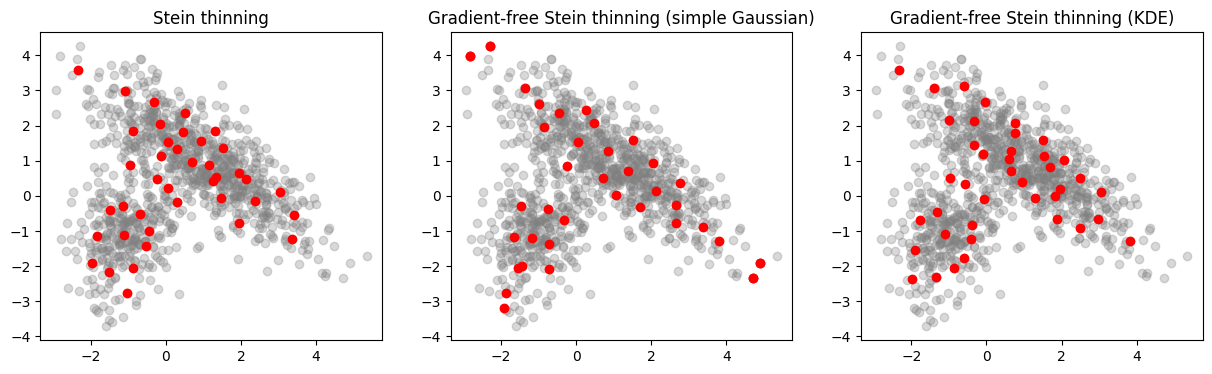

In [20]:
entries = [
    (idx_stein, 'Stein thinning'),
    (idx_gf, 'Gradient-free Stein thinning (simple Gaussian)'),
    (idx_gf_kde, 'Gradient-free Stein thinning (KDE)'),
]

fig, axs = plt.subplots(1, len(entries), figsize=(15, 4));
for i, (idx, title) in enumerate(entries):
    axs[i].scatter(sample[:, 0], sample[:, 1], alpha=0.3, color='gray');
    axs[i].scatter(sample[idx, 0], sample[idx, 1], color='red');
    axs[i].set_title(title);